# VGG with TensorFlow-Keras
*by Marvin Bertin*
<img src="../../images/keras-tensorflow-logo.jpg" width="400">

### Goals
- construct a VGG model with TF-Keras
- train and evaluate model on Cifar10 dataset
- perform hyperparameter tuning
- plot accuracy and loss over time

In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

tf_keras = tf.contrib.keras

# Model Hyperparameters

In [9]:
model_params = {
    "num_classes": 10, # number of classes
    "input_shape": (32, 32, 3), # input image size
    "conv_kernel": (3,3), # convolutional feature map size
    "pool_kernel": (2,2), # pooling window size
    "batch_size": 32 # number of samples per batch
}
hyper_params = {
    "l2_regularization": 0.0005,
    "dropout": 0.5, # ratio of neurons to drop during trainin
    "learning_rate": 0.0001 # learning rate
}

# Convolutional Block
The convolutional block is one of the building blocks of the VGG architecture. The actual composition of the block can vary across tasks. In this lesson, we're going to implement the following stack:

    Block: conv - batch norm - conv - maxpool - dropout
    
However, you are encourage to try other combinations and experiment training different types of blocks. for example:
    
    Block: batch norm - conv - batch norm - conv - maxpool - dropout
    Block: conv - batch norm - conv - batch norm - maxpool
    Block: conv - dropout - conv - dropout - maxpool


In [10]:
# convolutional layer
def conv2d(filters):
    return tf_keras.layers.Conv2D(filters, model_params["conv_kernel"],
                                 padding='same',
                                 activation=tf.nn.relu,
                                 kernel_regularizer=
                                  tf.contrib.layers.l2_regularizer(hyper_params["l2_regularization"]))

# Block: conv - BN - conv - maxpool - dropout
def convBlockFunction(filters, inputs):
    net = conv2d(filters)(inputs)
    net = tf_keras.layers.BatchNormalization()(net)
    net = conv2d(filters)(net)
    net = tf_keras.layers.MaxPool2D(model_params["pool_kernel"])(net)
    return tf_keras.layers.Dropout(0.25)(net)

# curried conv block
def convBlock(filters):
    def convBlockCurried(inputs):
        return convBlockFunction(filters,inputs)
    return convBlockCurried

# Fully Connect Block

Similarly for the dense block there are multiple ways to define them, here is one way:

    Block: dense - dropout

Other ways are:
    
    Block: dense - batch norm
    Block: dense - batch norm - dropout

In [11]:
# dense block
def denseBlockFunction(units, inputs):
    net = tf_keras.layers.Dense(units)(inputs)
    return tf_keras.layers.Dropout(hyper_params["dropout"])(net)

# curried dense block
def denseBlock(units):
    def denseBlockCurried(inputs):
        return denseBlockFunction(units, inputs)
    return denseBlockCurried

# VGG Implementation

In [12]:
def VGG():

    # TensorFlow default graph
    tf.reset_default_graph()

    # input image tensor
    inputs = tf_keras.layers.Input(shape=model_params["input_shape"])

    # convolutional blocks
    # Block: conv - BN - conv - maxpool - dropout
    net = convBlock(64)(inputs)
    net = convBlock(128)(net)
    net = convBlock(256)(net)

    net = tf_keras.layers.Flatten()(net)

    # fully connected blocks
    net = denseBlock(1024)(net)
    net = denseBlock(512)(net)

    # final layer
    outputs = tf_keras.layers.Dense(model_params["num_classes"],
                                    activation = tf.nn.softmax)(net)
    
    # model
    model = tf_keras.models.Model(inputs=inputs, outputs=outputs)
    
    return model

# Compile Model
Add the loss function, the optimizer, and the metrics to the model.

In [13]:
def compile_model(model):
    
    # loss
    loss = tf_keras.losses.categorical_crossentropy

    # Adam optimizer
    optimizer = tf_keras.optimizers.Adam(lr=hyper_params["learning_rate"])
    
    # metrics
    metrics = [tf_keras.metrics.categorical_accuracy,
               tf_keras.metrics.top_k_categorical_accuracy]
    

    # compile the model with loss, optimizer and evaluation metrics
    model.compile(loss = loss,
                  optimizer = optimizer,
                  metrics = metrics)

    print(model.summary())
    
    return model

In [14]:
vgg = VGG()
vgg = compile_model(vgg)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       73856     
__________

# Load and Vectorize Cifar10 Dataset

In [8]:
# load Cifar dataset
(x_train, y_train), (x_test, y_test) = tf_keras.datasets.cifar10.load_data()

# Turn target values into one-hot encoded vectors
y_train = tf_keras.utils.to_categorical(y_train, model_params["num_classes"])
y_test = tf_keras.utils.to_categorical(y_test, model_params["num_classes"])

# Data Augmentation

In [9]:
# data generator augmentation configuration for training
train_datagen = tf_keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# data generator augmentation configuration for testing
# only rescaling
test_datagen = tf_keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)

# Data Generators

In [10]:
# Training generator
train_generator = train_datagen.flow(x=x_train, y=y_train,
                                     batch_size=model_params["batch_size"])

# Testing generator
validation_generator = test_datagen.flow(x=x_test, y=y_test,
                                         batch_size=model_params["batch_size"])

# Train VGG on Cifar10

In [16]:
# fits the model on batches with real-time data augmentation
history = vgg.fit_generator(train_generator,
                            steps_per_epoch=300,#x_train.shape[0]//batch_size
                            epochs=10,
                            validation_data=validation_generator,
                            validation_steps=100)

Epoch 1/10
300/300 [==============================] - 15s - loss: 1.6976 - categorical_accuracy: 0.4527 - top_k_categorical_accuracy: 0.9132 - val_loss: 1.5912 - val_categorical_accuracy: 0.4899 - val_top_k_categorical_accuracy: 0.9259
Epoch 2/10
300/300 [==============================] - 15s - loss: 1.6954 - categorical_accuracy: 0.4590 - top_k_categorical_accuracy: 0.9139 - val_loss: 1.7587 - val_categorical_accuracy: 0.4559 - val_top_k_categorical_accuracy: 0.9263
Epoch 3/10
300/300 [==============================] - 15s - loss: 1.6462 - categorical_accuracy: 0.4736 - top_k_categorical_accuracy: 0.9270 - val_loss: 1.4531 - val_categorical_accuracy: 0.5316 - val_top_k_categorical_accuracy: 0.9459
Epoch 4/10
300/300 [==============================] - 16s - loss: 1.6251 - categorical_accuracy: 0.4780 - top_k_categorical_accuracy: 0.9284 - val_loss: 1.5547 - val_categorical_accuracy: 0.5182 - val_top_k_categorical_accuracy: 0.9337
Epoch 5/10
300/300 [==============================] - 15

# Evaluate Model Peformance

In [17]:
# evaluate the model on batches with real-time data augmentation
loss, acc, top_k_acc= vgg.evaluate_generator(validation_generator,
                                             steps = 200)
print("loss: {}".format(loss))
print("accuracy: {}".format(acc))
print("top 5 accuracy: {}".format(top_k_acc))

[1.2883292523026466, 0.62250000000000005, 0.96515625000000005]

# Make Predictions on Trained VGG

In [ ]:
# make predictions on batches with real-time data augmentation
predictions = vgg.predict_generator(validation_generator, steps = 100)

# Plot Accuracy and Loss Over Time

In [18]:
def plot_accuracy_and_loss(history):
    plt.figure(1, figsize= (15, 10))
    
    # plot train and test accuracy
    plt.subplot(221)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('vgg accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # plot train and test loss
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('vgg loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    
    plt.show()

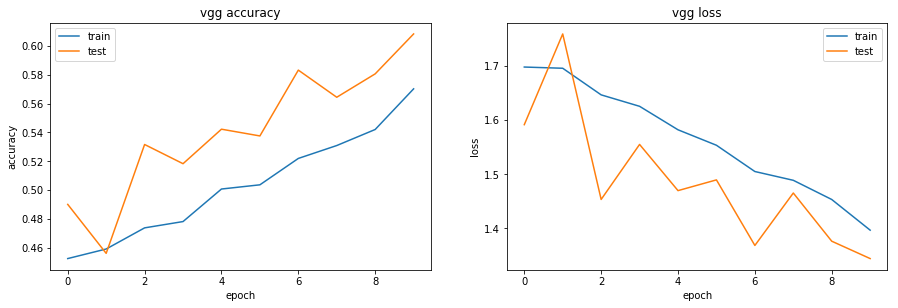

In [19]:
plot_accuracy_and_loss(history)

# Save Model Architecture And Weights

In [ ]:
#save model
vgg_json = vgg.to_json()
open('cifar10_vgg.json', 'w').write(vgg_json)
vgg.save_weights('image_classifier_cifar10.h5', overwrite=True)

## Next Lesson
### Transfer Learning
-  You will learn about feature extraction and fine tuning with transfer learning

<img src="../../images/divider.png" width="100">